# HW250527-Image_Classification_Problems

## Exercise 1
* Use LeNet, AlexNet to solve the image classification problem.
* the dataset is KMNIST provided by torchvision.datasets
* You can make proper modifications on LeNet and AlexNet.
* Discuss your modifications and recognition results

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

### use_deterministic_algorithms
注意: 此案例AlexNet，因為程式錯誤而未使用。
``` Python
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
```
用來支援 
``` Python
torch.use_deterministic_algorithms(True)
```

In [5]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

# torch.use_deterministic_algorithms(True, warn_only=True)
torch.use_deterministic_algorithms(False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### AlexNet
* RGB通道改成灰階，以適用KMNIST
* 調整 Output feature 1000 -> 10 對應 KMNIST
* to(device)
``` Python
model_finetune = model_finetune.to(device)
```
model 搬到 device 裡面計算，優先使用 GPU CUDA 而非 CPU

In [7]:
from torchvision import models

# model_finetune = models.alexnet(weights="AlexNet_Weights.DEFAULT")
model_finetune = models.alexnet()

old_conv = model_finetune.features[0]
new_conv = torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

with torch.no_grad():
    new_conv.weight[:] = old_conv.weight.mean(dim=1, keepdim=True)
    new_conv.bias[:] = old_conv.bias

model_finetune.features[0] = new_conv

print(model_finetune.features)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [8]:
print(model_finetune.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [9]:
# change the last layer from 1000 classes to 10 classes
model_finetune.classifier[6] = nn.Linear(4096, 10)
model_finetune = model_finetune.to(device)
print(device)
print(model_finetune.classifier)

cuda
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


### def train(net, trainloader, optim, epoch)
1. 從 trainloader 取資料
2. Activation -> backpropagation算梯度 -> optim更新
3. 每 1000 次 印出 Loss
* to(device)
``` Python
ip = ip.to(device)
ground_truth = ground_truth.to(device)
```

In [11]:
def train(net, trainloader, optim, epoch):
    # initialize loss
    loss_total = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # ip refers to the input images, and ground_truth refers to the output classes the images belong to
        ip, ground_truth = data
        ip           = ip.to(device)
        ground_truth = ground_truth.to(device)

        # zero the parameter gradients
        optim.zero_grad()

        # forward pass + backward pass + optimization step
        op = net(ip)
        loss = nn.CrossEntropyLoss()(op, ground_truth)
        loss.backward()
        optim.step()

        # update loss
        loss_total += loss.item()
        
        # print loss statistics
        if (i+1) % 1000 == 0:    # print at the interval of 1000 mini-batches
            print('[Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss_total / 200))
            loss_total = 0.0

### def test(net, testloader):
* to(device)
``` Python
im = im.to(device)
ground_truth = ground_truth.to(device)
```

In [13]:
def test(net, testloader):
    success = 0
    counter = 0
    with torch.no_grad():
        for data in testloader:
            im, ground_truth = data
            
            im           = im.to(device)
            ground_truth = ground_truth.to(device)
            
            op = net(im)
            _, pred = torch.max(op.data, 1)
            counter += ground_truth.size(0)
            success += (pred == ground_truth).sum().item()

    print('AlexNet accuracy on 1000 images from test dataset: %d %%' % (
        100 * success / counter))

### Dataset
* KMNIST  
https://docs.pytorch.org/vision/main/generated/torchvision.datasets.KMNIST.html  
https://github.com/rois-codh/kmnist
* Resize  
將KMNIST 28\*28的影像resize成 224\*224
* testloader batch_size 調低  
避免GPU OOM (Out of memory)

In [15]:
# The mean and std are kept as 0.5 for normalizing pixel values as the pixel values are originally in the range 0 to 1
# train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
#                                       transforms.RandomCrop(32, 4),
#                                       transforms.ToTensor(),
#                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_transform = transforms.Compose([transforms.Resize(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)


# test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)


# ordering is important
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = ('o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo')

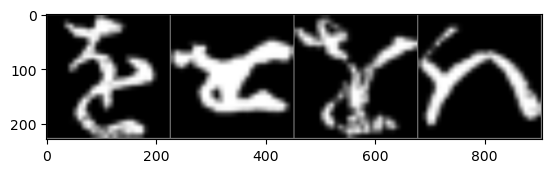

    wo  ||  wo  ||  wo  ||  ha


In [16]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# define a function that displays an image
def imageshow(image):
    # un-normalize the image
    image = image/2 + 0.5     
    npimage = image.numpy()
    plt.imshow(np.transpose(npimage, (1, 2, 0)))
    plt.show()


# sample images from training set
dataiter = iter(trainloader)
images, labels = next(dataiter)

# display images in a grid
num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))
# print labels
print('    '+'  ||  '.join(classes[labels[j]] for j in range(num_images)))

In [17]:
# define optimizer
optim = torch.optim.Adam(model_finetune.parameters(), lr=1e-4)

# training loop over the dataset multiple times
for epoch in range(50):  
    train(model_finetune, trainloader, optim, epoch)
    print()
    print("testing")
    test(model_finetune, testloader)
    print()

print('Finished Training')

[Epoch number : 1, Mini-batches:  1000] loss: 6.188
[Epoch number : 1, Mini-batches:  2000] loss: 2.364
[Epoch number : 1, Mini-batches:  3000] loss: 1.592
[Epoch number : 1, Mini-batches:  4000] loss: 1.209
[Epoch number : 1, Mini-batches:  5000] loss: 1.087
[Epoch number : 1, Mini-batches:  6000] loss: 0.859
[Epoch number : 1, Mini-batches:  7000] loss: 0.864

testing
AlexNet accuracy on 1000 images from test dataset: 87 %

[Epoch number : 2, Mini-batches:  1000] loss: 0.719
[Epoch number : 2, Mini-batches:  2000] loss: 0.654
[Epoch number : 2, Mini-batches:  3000] loss: 0.597
[Epoch number : 2, Mini-batches:  4000] loss: 0.595
[Epoch number : 2, Mini-batches:  5000] loss: 0.517
[Epoch number : 2, Mini-batches:  6000] loss: 0.545
[Epoch number : 2, Mini-batches:  7000] loss: 0.510

testing
AlexNet accuracy on 1000 images from test dataset: 92 %

[Epoch number : 3, Mini-batches:  1000] loss: 0.442
[Epoch number : 3, Mini-batches:  2000] loss: 0.457
[Epoch number : 3, Mini-batches:  30

In [18]:
model_path = './AlexNet_kmnist_model.pth'
torch.save(model_finetune.state_dict(), model_path)

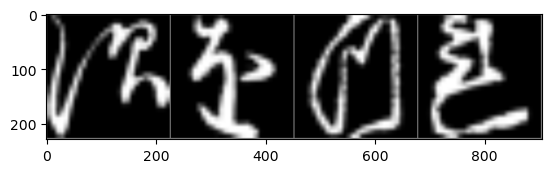

Label:          su    wo   tsu    re
Prediction:     su    wo   tsu    re


In [26]:
# load test dataset images
d_iter = iter(testloader)
im, ground_truth = next(d_iter)

# print images and ground truth
imageshow(torchvision.utils.make_grid(im[:4]))
print('Label:      ', ' '.join('%5s' % classes[ground_truth[j]] for j in range(4)))

# load model
alexnet_cached = model_finetune
alexnet_cached.load_state_dict(torch.load(model_path))

# model inference
im = im.to(device)
ground_truth = ground_truth.to(device)
op = alexnet_cached(im)

# print predictions
_, pred = torch.max(op, 1)

print('Prediction: ', ' '.join('%5s' % classes[pred[j]] for j in range(4)))

In [38]:
success = 0
counter = 0
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        im = im.to(device)
        ground_truth = ground_truth.to(device)
        op = alexnet_cached(im)
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

print('Model accuracy on 1000 images from test dataset: %d %%' % (
    100 * success / counter))

Model accuracy on 1000 images from test dataset: 96 %


In [40]:
class_sucess = list(0. for i in range(10))
class_counter = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        im = im.to(device)
        ground_truth = ground_truth.to(device)
        op = alexnet_cached(im)
        _, pred = torch.max(op, 1)
        c = (pred == ground_truth).squeeze()
        for i in range(1000):
            ground_truth_curr = ground_truth[i]
            class_sucess[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1


for i in range(10):
    print('Model accuracy for class %5s : %2d %%' % (
        classes[i], 100 * class_sucess[i] / class_counter[i]))

Model accuracy for class     o : 97 %
Model accuracy for class    ki : 93 %
Model accuracy for class    su : 93 %
Model accuracy for class   tsu : 98 %
Model accuracy for class    na : 96 %
Model accuracy for class    ha : 96 %
Model accuracy for class    ma : 97 %
Model accuracy for class    ya : 95 %
Model accuracy for class    re : 98 %
Model accuracy for class    wo : 98 %
